In [1]:
from transformers import LayoutLMv3FeatureExtractor
from transformers import LayoutLMv3Tokenizer
from PIL import Image
import os 
from utils import utils
import torch
import sys
# 一個上の階層をpathに追加
sys.path.append('../')
from model import mlm_layoutLMv3 
import matplotlib.pyplot as plt

/home/is/hikaru-si/.pyenv/versions/3.8.6/envs/exp_004/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../../datasets/pdfs/images/ex"
image_names = os.listdir(file_path)
len(image_names)

100

In [3]:
file_names = []
for n in image_names:
    name = os.path.splitext(n)[0]
    file_names.append(name)
image_names.clear()

In [4]:
file_path = "../../datasets/pdfs/train/"

In [5]:
words, bboxes = utils.extraction_text_from_pdf(file_path, file_names)

In [6]:
# tokenizer = LayoutLMv3Tokenizer("../code/layoutlmv3-publaynet/vocab.json", "../code/layoutlmv3-publaynet/merges.txt")
# enc = tokenizer(text=words, boxes = bboxes, add_special_tokens=False)


In [7]:
# tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")
# enc = tokenizer(text=words, boxes = bboxes, add_special_tokens=False)

In [8]:
tokenizer = LayoutLMv3Tokenizer("../model/tokenizer_vocab/vocab.json", "../model/tokenizer_vocab/merges.txt")
enc = tokenizer(text=words, boxes = bboxes, add_special_tokens=False)

In [32]:
pixel_values = []
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
for file_name in file_names[:100]:
    image = Image.open(f"../../datasets/pdfs/images/train/{file_name}.png")
    pixel_value = feature_extractor(image)["pixel_values"]
    pixel_values.append(pixel_value)


len(pixel_values)

100

In [36]:
pixel_values[0][0].shape

(3, 224, 224)

In [37]:
pixel_values[0].shape

AttributeError: 'list' object has no attribute 'shape'

## vocab

In [11]:
# tokenizer_o = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-base")
# ids = range(tokenizer_o.vocab_size)
# vocab_o = tokenizer_o.convert_ids_to_tokens(ids)
# vocab_o.index("That")

In [12]:
# vocab_o.index("benz")

In [13]:
# tokenizer = LayoutLMv3Tokenizer("../code/layoutlmv3-publaynet/vocab.json", "../code/layoutlmv3-publaynet/merges.txt")
# ids = range(tokenizer.vocab_size)
# vocab = tokenizer.convert_ids_to_tokens(ids)
# # vocab.index("benz")

In [14]:
# tokenizer.tokenize("I have a Ggorge and Apple.", )

In [38]:
tokenizer = LayoutLMv3Tokenizer("../model/tokenizer_vocab/vocab.json", "../model/tokenizer_vocab/merges.txt")
ids = range(tokenizer.vocab_size)
vocab = tokenizer.convert_ids_to_tokens(ids)
vocab.index("benz")

9030

In [39]:
# tokenzier = LayoutLMv3Tokenizer("../code")

## SEPを追加

In [40]:
# for i in range(len(enc.input_ids)):
#     enc.input_ids[i], enc.bbox[i] = utils.add_sep_tokens(enc.input_ids[i], enc.bbox[i], vocab)

## 512の長さに分割

In [41]:
tokens, bboxes, doc_ids = utils.subset_tokens_from_document_light(enc.input_ids, enc.bbox, vocab, max_len=512)

In [42]:
len(tokens), len(doc_ids), doc_ids[:10]

(223, 223, [0, 0, 1, 1, 2, 3, 3, 4, 4, 4])

In [43]:
pixel[0].shape

NameError: name 'pixel' is not defined

In [22]:
!nvidia-smi

Mon Aug 15 11:52:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:81:00.0 Off |                  Off |
| 30%   37C    P8    35W / 300W |      3MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:C1:00.0 Off |                  Off |
| 30%   

## train_dataloader を作成

In [20]:
# encoding = {"input_ids": o_tokens, "attention_mask": t[2], "bbox": t[1], "pixel_values":t[3], }
dataset = []
for i in range(len(tokens)):
    dataset.append({"input_ids": torch.tensor(tokens[i]),"bbox": torch.tensor(bboxes[i]), "pixel_values": pixel_values[doc_ids[i]].squeeze()})

In [21]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size= 16, shuffle=True)

## maskしながらmodelに入力する

In [25]:
# from transformers import AutoConfig, AutoModel
# config = AutoConfig.from_pretrained("microsoft/layoutlmv3-base")
# model = AutoModel.from_config(config)

In [19]:
from transformers import AutoConfig, AutoModel
config = AutoConfig.from_pretrained("microsoft/layoutlmv3-base")
model = mlm_layoutLMv3.LayoutLMv3ForMLM(config)

In [27]:
model.state_dict()["model.encoder.layer.1.attention.output.dense.weight"]

tensor([[ 6.9454e-03,  1.8495e-05, -1.4109e-02,  ..., -2.5269e-02,
          3.6433e-02,  3.3779e-02],
        [-9.6295e-03, -8.7798e-03, -2.4761e-02,  ...,  8.8307e-03,
          2.5403e-02, -2.5944e-02],
        [-1.7304e-02, -4.9060e-03, -1.4442e-02,  ...,  3.1196e-02,
         -3.7666e-02, -1.2924e-02],
        ...,
        [-1.6131e-02, -1.4696e-02, -8.0366e-04,  ...,  1.7884e-02,
          2.1644e-02,  3.3715e-02],
        [ 6.1683e-03,  1.4551e-02,  2.6038e-02,  ...,  1.3279e-02,
         -9.7476e-03, -1.3197e-02],
        [ 1.8607e-02,  2.9514e-02,  3.6733e-03,  ..., -1.0056e-02,
         -4.7651e-03, -2.1116e-02]])

In [28]:
model.load_state_dict(torch.load("../model/init_layoutLMv3.params"))

/home/is/hikaru-si/.pyenv/versions/3.8.6/envs/exp_002/lib/python3.8/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA RTX A6000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A6000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


<All keys matched successfully>

In [29]:
model.state_dict()["model.encoder.layer.1.attention.output.dense.weight"]

tensor([[-0.0038,  0.0092, -0.0031,  ...,  0.0078,  0.0316,  0.0366],
        [-0.0315,  0.0016, -0.0095,  ...,  0.0054,  0.0238,  0.0034],
        [-0.0127,  0.0063,  0.0212,  ...,  0.0104, -0.0035,  0.0010],
        ...,
        [-0.0166, -0.0208,  0.0055,  ..., -0.0146,  0.0065,  0.0144],
        [-0.0205,  0.0102,  0.0090,  ...,  0.0061,  0.0058,  0.0053],
        [-0.0193, -0.0002,  0.0396,  ...,  0.0017, -0.0105,  0.0173]])

In [30]:
model.load_state_dict(torch.load("../model/pretrained_layoutLMv3.params"))
model.state_dict()["model.encoder.layer.1.attention.output.dense.weight"]

tensor([[ 0.0250,  0.0022,  0.0254,  ..., -0.0070, -0.0364,  0.0168],
        [ 0.0030,  0.0336,  0.0052,  ..., -0.0266,  0.0553, -0.0519],
        [ 0.0021, -0.0116,  0.0189,  ...,  0.0035,  0.0164,  0.0020],
        ...,
        [ 0.0057,  0.0026, -0.0177,  ..., -0.0415,  0.0062,  0.0126],
        [ 0.0246,  0.0319,  0.0192,  ...,  0.0006,  0.0433,  0.0386],
        [ 0.0055,  0.0072, -0.0026,  ...,  0.0245, -0.0015, -0.0343]])

In [22]:
#optimizer 
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

#cross entropy
loss_fn = torch.nn.CrossEntropyLoss()


In [32]:
model.state_dict()["model.encoder.layer.1.attention.output.dense.weight"]

tensor([[ 0.0250,  0.0022,  0.0254,  ..., -0.0070, -0.0364,  0.0168],
        [ 0.0030,  0.0336,  0.0052,  ..., -0.0266,  0.0553, -0.0519],
        [ 0.0021, -0.0116,  0.0189,  ...,  0.0035,  0.0164,  0.0020],
        ...,
        [ 0.0057,  0.0026, -0.0177,  ..., -0.0415,  0.0062,  0.0126],
        [ 0.0246,  0.0319,  0.0192,  ...,  0.0006,  0.0433,  0.0386],
        [ 0.0055,  0.0072, -0.0026,  ...,  0.0245, -0.0015, -0.0343]])

In [33]:
model.module.state_dict()["model.encoder.layer.1.attention.output.dense.weight"]

AttributeError: 'LayoutLMv3ForMLM' object has no attribute 'module'

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model.to(device)
device

'cuda'

In [24]:
device_ids = list(range(torch.cuda.device_count()))
device_ids

[0, 1]

In [25]:
model = torch.nn.DataParallel(model, device_ids = device_ids)
model = model.to(f'cuda:{model.device_ids[0]}')

In [34]:
# if device == 'cuda':
#     model = torch.nn.DataParallel(model, device_ids=[0, 1]) # make parallel

In [35]:
# torch.cuda.empty_cache()

In [30]:
torch.cuda.is_available()

True

In [37]:
# if device == 'cuda':
#     model = torch.nn.DataParallel(model) # make parallel
# model.train()

In [40]:
%%time

import random
num_epochs = 1

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model.to(device)
# if device == 'cuda':
#     model = torch.nn.DataParallel(model) # make parallel
# model.train()

count = 0
loss_list = []
for epcoh in range(num_epochs):
    for inputs in data_loader:
        inputs["input_ids"], maske_positions, labels = utils.batch_create_span_mask(inputs["input_ids"], 0.3, 153, vocab, 3, random)
        # inputs["maske_positions"] = maske_positions
        # inputs["labels"] = labels
        inputs = {k: v.to(device) for k, v in inputs.items()}
        for k, v in inputs.items():
            print(k, v.device)
        logits = model.forward(inputs)
        
        t = []
        for i in range(len(maske_positions)):
            if len(maske_positions[i]) == 0:
                continue
            maske_positions[i].to(device)
            t.append(logits[i][maske_positions[i]])
        logits = torch.cat(t)
        labels = torch.cat(labels)
        print(labels.shape, labels.device)
        labels = labels.to(device)
        print(labels.device)
        
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print(loss.item())
        
        # loss_list.append(loss.item())

        


        

        # logits = logits.contiguous().view(1, -1, 50265)

        # loss(logits,)
        count += 1
        print(logits.shape)
        
        
        # loss= torch.nn.CrossEntropyLoss()
    
    
#encoding = {"input_ids": o_tokens, "attention_mask": t[2], "bbox": t[1], "pixel_values":t[3], }
   

NameError: name 'device' is not defined

11.020061492919922
10.498808860778809
10.318747520446777
10.1331205368042
10.058197021484375
9.918319702148438
9.898950576782227
9.892008781433105
9.69887638092041
9.843184471130371
9.713077545166016
9.58130931854248
9.647113800048828
9.625062942504883
CPU times: user 12.2 s, sys: 5.38 s, total: 17.6 s
Wall time: 11.1 s


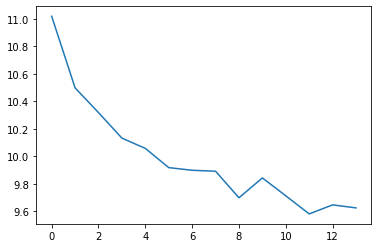

: 

In [27]:
%%time

import random
num_epochs = 1

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = model.to(device)
# if device == 'cuda':
#     model = torch.nn.DataParallel(model) # make parallel
# model.train()


loss_list = []
for epcoh in range(num_epochs):
    for inputs in data_loader:
        inputs["input_ids"], maske_positions, labels = utils.batch_create_span_mask(inputs["input_ids"], 0.3, 153, vocab, 3, random)
        # inputs["maske_positions"] = maske_positions
        # inputs["labels"] = label
        inputs = {k: v.to(f'cuda:{model.device_ids[0]}') for k, v in inputs.items()}

        logits = model.forward(inputs)
        t = []
        for i in range(len(maske_positions)):
            if len(maske_positions[i]) == 0:
                continue
            # maske_positions[i].to(model.device_ids[0])
            t.append(logits[i][maske_positions[i]])
        logits = torch.cat(t)
        labels = torch.cat(labels)
    
        labels = labels.to(f'cuda:{model.device_ids[0]}')
        
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(loss.item())
        
        loss_list.append(loss.item())
        

        # logits = logits.contiguous().view(1, -1, 50265)

        # loss(logits,)

        
plt.plot(range(len(loss_list)), loss_list)
        
        # loss= torch.nn.CrossEntropyLoss()

In [54]:
model.device_ids[0]

0

In [45]:
!nvidia-smi

Sun Aug 14 23:06:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:81:00.0 Off |                  Off |
| 30%   40C    P8    37W / 300W |  48614MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:C1:00.0 Off |                  Off |
| 30%   

In [43]:
labels.device

device(type='cpu')

In [44]:
labels.to(device),

tensor([  476, 15754,   436,  2263,   262,  5174,   303,  1135,   402,    26,
          455,   280,   271,  3204,  1338,  7448,    16,  5032,   285,  5988,
          295,  2846,   364,   261,   550,   280,   641,    16,   342, 16973,
         5508,   334,   271,   364,   271,  2583,   285,   271, 15000,  5703,
          334,  3202,   303,  2920,   285,  8837,  6179,  7881,   605, 11204,
          428,   271,  8536,    18,   342,   659,   759,    18,  8536, 27039,
          285, 40321,  2696,   295,  1468, 14769,   402,   607,    16,   709,
          455,  1754,  1499,   334,  8536, 27039,  3385, 16988, 16973, 16412,
          280,  5846,  1343,   382,  1678,   428,  2838,  2149,  4886,  8536,
        27039, 14334,    18, 16988,   733,    22,   768, 11335,  9265,   262,
         7074,  1546,    16, 14334,  2806,  3298,  1166, 43165,   450,   340,
           31,  7218,  4061,  2449,   431,   351,  3516,  2701,   299,  1773,
         1422,  4643,    18,  1260,    19,  4914,    19,  1139, 

In [34]:
torch.__version__, torch.cuda.is_available()

('1.12.1+cu102', True)

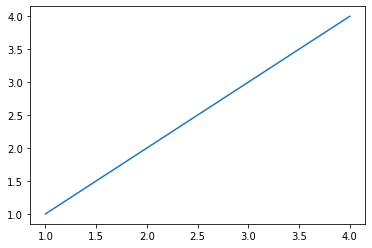

In [ ]:
x = [1,2,7,4]
y = x
plt.plot(x, y)
# plt.savefig("sin.png")   # プロットしたグラフをファイルsin.pngに保存する
plt.show()

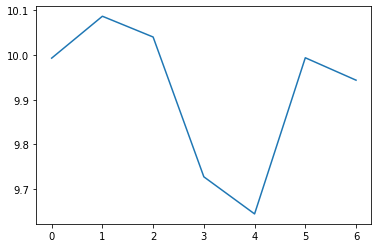

In [78]:
plt.plot(range(len(loss_list)),loss_list)

In [73]:
loss.item()

11.030715942382812

In [47]:
# torch.ones(10)[torch.tensor([])]
len(torch.tensor([])) == 0

True

In [69]:
print(logits.shape)
print(len(maske_positions[0]))
ll = logits.contiguous().view(1, -1, 50265)
print(ll.shape)

torch.Size([2, 512, 50265])
129
torch.Size([1, 1024, 50265])


In [36]:
logits[0][maske_positions[0]].shape, logits[1][maske_positions[1]].shape

(torch.Size([54, 50265]), torch.Size([133, 50265]))

In [83]:
logits_seq = torch.cat((logits[0][maske_positions[0]], logits[1][maske_positions[1]]), 0)
logits_seq

tensor([[-0.1313, -0.5061,  0.6517,  ..., -0.0642, -0.1783, -0.4181],
        [-1.0116, -0.8329, -0.1120,  ..., -0.3461, -0.6661, -0.5902],
        [-1.0124, -0.7456,  0.6907,  ..., -1.7858, -0.3030, -0.7450],
        ...,
        [-0.7402, -0.1163,  0.1100,  ..., -1.0482,  0.1790, -0.2885],
        [-0.4239, -0.7593,  0.1597,  ..., -0.4213, -0.4730, -0.0987],
        [-0.1735, -0.0405,  0.1013,  ..., -0.0642, -0.6314, -0.0045]],
       grad_fn=<CatBackward0>)

In [96]:
t = []
for i in range(len(maske_positions)):
  t.append(logits[i][maske_positions[i]])
torch.cat(t).shape

torch.Size([260, 50265])

In [41]:
labels_seq = torch.cat(labels)
labels_seq.shape

[tensor([ 1161, 19039,    32, 37057,    15,     5,   994,    32, 29892,   176,
             6,   208,  6447,   406,   250,   245,     6,   387,   134,     6,
           230,  2685,   387,     6,  7522,   725,  1558,     6, 21137,   487,
           134,     6,   208, 14505,   176,     8,    83,   176, 31799,    43,
            58, 11236,    19,   209,  7006, 39919,  1178, 13447, 29892,   176,
             4,  2668,  2379,  4400]),
 tensor([43631,     9,  6150,    25,   157,    25,     5,  5984,  3738,     9,
            97,  4898,     9,   474, 12409,  1265,     6,     7,  4010, 16409,
             5, 11593,  1265,    23,    70,  1389,     6,     8,    45,   129,
            23,     5,  6570,   359,   103, 17332,  2452,   238,     5,  2803,
             9,  1309,    36,  1990,     5, 27652,    76,   359, 17332,  2452,
           238,  3717,  4898,     8,  3353,    36, 34663,    13, 17332,  2452,
           238,     5,  2803,     9, 23709,   368, 24802,    36,  1990,    92,
          417

In [85]:
loss(logits_seq, labels_seq)

tensor(10.9799, grad_fn=<NllLossBackward0>)

In [44]:
logits[1][0] == ll[0][512], (logits[1][511] == ll[0][1023]).sum()

(tensor([True, True, True,  ..., True, True, True]), tensor(50265))

In [22]:
len(torch.te)

2

In [308]:
inputs.keys()
inputs["pixel_values"].shape

torch.Size([2, 3, 224, 224])

## appendix

In [109]:
model.state_dict().keys()
model.state_dict()["model.embeddings.word_embeddings.weight"]

torch.Tensor

In [48]:
model.model.dummy_inputs

{'input_ids': tensor([[7, 6, 0, 0, 1],
         [1, 2, 3, 0, 0],
         [0, 0, 0, 4, 5]])}

In [58]:
model.parameters

<bound method Module.parameters of layoutLMv3ForMLM(
  (model): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): Lay

In [37]:
from transformers import RobertaModel
Roberta_model = RobertaModel.from_pretrained("roberta-base")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
50000*512 /360000

71.11111111111111

In [39]:
Roberta_model.state_dict().keys()
#Robert word_embedding weight 
Roberta_model.state_dict()["embeddings.word_embeddings.weight"]

tensor([[ 0.1476, -0.0365,  0.0753,  ..., -0.0023,  0.0172, -0.0016],
        [ 0.0156,  0.0076, -0.0118,  ..., -0.0022,  0.0081, -0.0156],
        [-0.0347, -0.0873, -0.0180,  ...,  0.1174, -0.0098, -0.0355],
        ...,
        [ 0.0304,  0.0504, -0.0307,  ...,  0.0377,  0.0096,  0.0084],
        [ 0.0623, -0.0596,  0.0307,  ..., -0.0920,  0.1080, -0.0183],
        [ 0.1259, -0.0145,  0.0332,  ...,  0.0121,  0.0342,  0.0168]])

In [41]:
model.state_dict()["model.embeddings.word_embeddings.weight"] == Roberta_model.state_dict()["embeddings.word_embeddings.weight"]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [75]:
model.model.state_dict()

OrderedDict([('cls_token',
              tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 0

In [123]:
model.state_dict()["model.embeddings.word_embeddings.weight"][0][0]

tensor(0.0078)

In [124]:
model.state_dict()["model.embeddings.word_embeddings.weight"][0] = Roberta_model.state_dict()["embeddings.word_embeddings.weight"][0]


In [125]:
model.state_dict()["model.embeddings.word_embeddings.weight"][0][0]

tensor(0.1476)

In [134]:
weight_size = model.state_dict()["model.embeddings.word_embeddings.weight"].shape
weight_size

torch.Size([50265, 768])

In [110]:
v = torch.tensor([1, 2, 3])
w = torch.tensor([4, 5, 6])

In [141]:
weight_size = model.state_dict()["model.embeddings.word_embeddings.weight"].shape
for i in range(weight_size[0]):
  model.state_dict()["model.embeddings.word_embeddings.weight"][i] = Roberta_model.state_dict()["embeddings.word_embeddings.weight"][i]

In [142]:
model.state_dict()["model.embeddings.word_embeddings.weight"]

tensor([[ 0.1476, -0.0365,  0.0753,  ..., -0.0023,  0.0172, -0.0016],
        [ 0.0156,  0.0076, -0.0118,  ..., -0.0022,  0.0081, -0.0156],
        [-0.0347, -0.0873, -0.0180,  ...,  0.1174, -0.0098, -0.0355],
        ...,
        [ 0.0304,  0.0504, -0.0307,  ...,  0.0377,  0.0096,  0.0084],
        [ 0.0623, -0.0596,  0.0307,  ..., -0.0920,  0.1080, -0.0183],
        [ 0.1259, -0.0145,  0.0332,  ...,  0.0121,  0.0342,  0.0168]])

In [143]:
Roberta_model.state_dict()["embeddings.word_embeddings.weight"]

tensor([[ 0.1476, -0.0365,  0.0753,  ..., -0.0023,  0.0172, -0.0016],
        [ 0.0156,  0.0076, -0.0118,  ..., -0.0022,  0.0081, -0.0156],
        [-0.0347, -0.0873, -0.0180,  ...,  0.1174, -0.0098, -0.0355],
        ...,
        [ 0.0304,  0.0504, -0.0307,  ...,  0.0377,  0.0096,  0.0084],
        [ 0.0623, -0.0596,  0.0307,  ..., -0.0920,  0.1080, -0.0183],
        [ 0.1259, -0.0145,  0.0332,  ...,  0.0121,  0.0342,  0.0168]])